In [1]:
import numpy as np
import os
from pImpactR import MLI as mli
from pImpactR import opt
from pImpactR.util import Me
from copy import deepcopy as copy
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nturn = 2048
npt = 64
std = 0.15
Espread = 2.0e-3
OnEnergy = False

# Read MLI input for settings

In [3]:
elems,latticeList,labor = mli.readInputfile('mli.in.t3_iota_8_4_t0p4')
# elems[2].driftexact=1
elems,latticeList=mli.sext2thin(elems,latticeList,brho=0.50204778184582999)

setarclen is not recognized. skipping...
autoconcat is not recognized. skipping...
autoapply is not recognized. skipping...
reftraj is not recognized. skipping...
fit is not recognized. skipping...
bip is not recognized. skipping...
tip is not recognized. skipping...


In [5]:
for item in elems:
    if item.name=='mapout':
        print(item)


   elem: 'ptm'
   name: 'mapout'
 matrix: 3
   poly: 3


In [4]:
elemList = []
for item in elems:
    if not item.elem in ['tasm','aim','vary','anaprint','monitor']:
        elemList.append(item)

In [5]:
energy=elems[0].energy*1.0e9
gam0 = energy/Me
bet0 = np.sqrt(1.0-1.0/gam0**2)

In [6]:
NL_nu = 0.3
NL_L  = 1.8
NL_c  = 0.01
NL_t  = 0.4
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
k = 2*alfx/betx


f3 = k/(2*bet0)
f4 = k/(2*bet0*gam0)**2
print(bet0,k,f3,f4)

0.99999423665409 1.4544633270832747 0.727235854853427 4.191323867725334e-06


In [7]:
def MLI2norm(data_in,sign=1):
    data=data_in.copy()
    data[:,5] = np.sqrt(1.0-2.0*data[:,5]/bet0+data[:,5]**2)-1.0
    data[:,1] = (data[:,0]*alfx*sign/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx*sign/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    return data
    
def norm2MLI(data_in,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c
    data[:,5] = -np.sqrt((1.0+data[:,5])**2+1.0/(bet0*gam0)**2)+1.0/bet0
    return data

In [8]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10,n=1):
    f = truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return f.rvs(n)

In [9]:
# pData0 = np.load('pDataNorm.npy')
# pDataIn = norm2MLI(pData0,sign=1)
# np.savetxt('rays.in',pDataIn)

In [10]:
x=get_truncated_normal(sd=std,low=-2.0*std,upp=2.0*std,n=npt*5)
pData=np.zeros([npt,6])
pData[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData[:,5] = pData[:,5]/std*Espread
np.save('pDataNorm.std=0.15',pData)
# # pData = np.load('pDataNorm.std=0.1.npy')
# if OnEnergy:
#     pData[:,5] = 0.0

pDataIn = norm2MLI(pData,sign=1)
np.savetxt('rays.in',pDataIn)

# Cmds

In [11]:
raysin  =mli.getElem.raytrace(file1='rays.in',type='readonly')
dump    =mli.getElem.particledump(file='rays.out',precision=15)
track   =mli.getElem.autotrack(type='symplectic',order=5)
fin     =mli.getElem.fin

elemList = elemList + [raysin, dump, track, fin]

In [12]:
# labor = mli.buildLabor(['iotaline','mapout'])
# mli.writeInputfile(elemList,latticeList,labor)
# mli.run()

# Lattice

In [13]:
nlinsert=mli.getElem.nlinsert()

iotaline = latticeList[0]
arc = copy(iotaline)
arc.name = 'arc'
iotaline.list.insert(0,nlinsert.name)
iotaline.list.append(dump.name)

elemList = elemList + [nlinsert]

In [14]:
indexThin = []
for i,item in enumerate(elemList):
    if 'thlm' == item.elem:
        indexThin.append(i)
nThin = len(indexThin)
print(nThin)

18


# Labor

In [15]:
labor = mli.buildLabor(['iotaline','mapout','clear',raysin.name,track.name,str(nturn)+'*'+iotaline.name,'fin'])
maplabor = mli.buildLabor(['arc','mapout'])

#  Run

In [16]:
def getTBT(npt,nturn,fname='rays.out'):
    TBT = np.loadtxt(fname)
    TBT = TBT[:npt*nturn,:6]
    out = np.zeros([npt,nturn,6])
    for i in range(nturn):
        out[:,i,:] = TBT[i*npt:(i+1)*npt,:]
        out[:,i,:] = MLI2norm(out[:,i,:])
    return out

In [17]:
def updateStrength(arg):
    for i,j in enumerate(indexThin):
        elemList[j]['k2l']=arg[i]
    for i,j in enumerate(indexThin):
        elemList[j]['k3l']=arg[i+nThin]

In [18]:
updateStrength([0.0]*2*nThin)
mli.writeInputfile(elemList,latticeList,labor)
mli.run(8)
!mv mli.log mli.0.log
TBT0 = getTBT(npt,nturn)
print(TBT0.shape)

(64, 2048, 6)


In [19]:
import pickle
# with open('result.thin.sext.oct','rb') as fp:
# with open('result.thin.DA.sext','rb') as fp:
with open('result.thin.2sig.sext','rb') as fp:
    result=pickle.load(fp)

In [20]:
updateStrength(result.x)
mli.writeInputfile(elemList,latticeList,labor)
mli.run(8)
!mv mli.log mli.1.log
TBT1 = getTBT(npt,nturn)
print(TBT1.shape)

(64, 2048, 6)


In [21]:
mli.writeInputfile(elemList,[arc],maplabor)
mli.run()
M,G=mli.readTransferMap()

In [22]:
readmap = mli.getElem.tmi(name='readmap')
readmap.map2file(M,G)
savemap = mli.getElem.stm(name='savemap')
arcM    = mli.getElem.gtm(name='arcM')
elemList = elemList + [readmap,savemap,arcM]
iotaline.list=[iotaline.list[0],'arcM',iotaline.list[-1]]
labor.list = ['readmap','savemap','arcM','clear'] + labor.list[-4:]
mli.writeInputfile(elemList,latticeList,labor)
mli.run(8)
!mv mli.log mli.2.log
TBT2 = getTBT(npt,nturn)
print(TBT2.shape)

(64, 2048, 6)


# Check invariants

In [23]:
def getInv(xn,pxn,yn,pyn,delta,tau=NL_t):
    z = xn + 1j*yn
    U = np.real(z/np.sqrt(1-z**2)*np.arcsin(z))
    W = np.real(2*xn/np.sqrt(1-z**2)*np.arcsin(z))
    Hn = 0.5*(xn**2+pxn**2+yn**2+pyn**2)   +tau*U/(1.0+delta)
    In = (xn*pyn -yn*pxn)**2 +xn**2+pxn**2 +tau*W/(1.0+delta)
    return Hn,In

def getInvTBT(TBT):
    npt,nturn,dummy = TBT.shape
    InvTBT = np.zeros([npt,nturn,2])
    for iturn in range(nturn):
        data = TBT[:,iturn,:]
        for ipt in range(npt):
            xn    = data[ipt,0]
            pxn   = data[ipt,1]
            yn    = data[ipt,2]
            pyn   = data[ipt,3]
            delta = data[ipt,5]
            InvTBT[ipt,iturn,:] = getInv(xn,pxn,yn,pyn,delta)
    return InvTBT

In [24]:
Inv0 = getInvTBT(TBT0)
Inv1 = getInvTBT(TBT1)
Inv2 = getInvTBT(TBT2)

### Absolute

In [25]:
print('--max invarinats--')
print(np.max(Inv0[:,:,0]),np.max(Inv0[:,:,1]))
print(np.max(Inv1[:,:,0]),np.max(Inv1[:,:,1]))
print(np.max(Inv2[:,:,0]),np.max(Inv2[:,:,1]))

--max invarinats--
0.11742314717049629 0.20011108489579055
nan nan
nan nan


In [26]:
amp0 = np.zeros([npt,2])
amp1 = np.zeros([npt,2])
amp2 = np.zeros([npt,2])
for i in range(npt):
    amp0[i,0] = np.std(Inv0[i,:,0])
    amp0[i,1] = np.std(Inv0[i,:,1])
    amp1[i,0] = np.std(Inv1[i,:,0])
    amp1[i,1] = np.std(Inv1[i,:,1])
    amp2[i,0] = np.std(Inv2[i,:,0])
    amp2[i,1] = np.std(Inv2[i,:,1])
print('--mean of amplitudes--')
print(amp0[:,0].mean(),amp0[:,1].mean())
print(amp1[:,0].mean(),amp1[:,1].mean())
print(amp2[:,0].mean(),amp2[:,1].mean())

--mean of amplitudes--
0.0014074819578984597 0.0021355457126730768
nan nan
nan nan


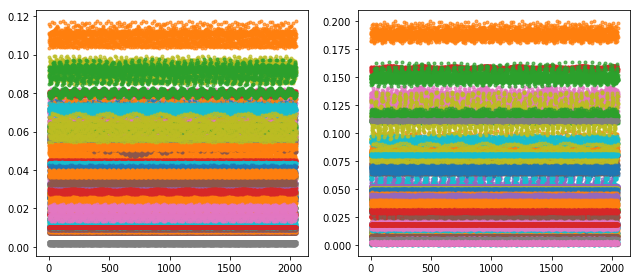

In [27]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

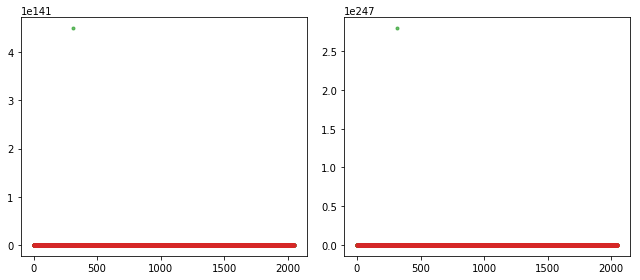

In [28]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

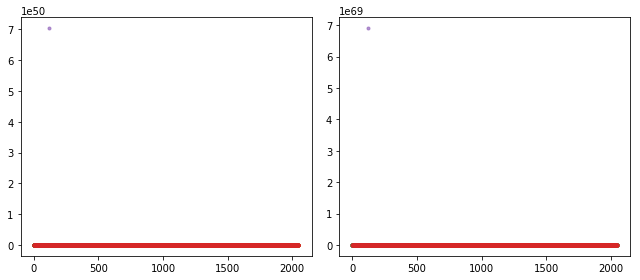

In [29]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv2[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv2[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

### Relative

In [30]:
for i in range(npt):
    Inv0[i,:,0] = Inv0[i,:,0]/Inv0[i,0,0].mean()-1.0
    Inv0[i,:,1] = Inv0[i,:,1]/Inv0[i,0,1].mean()-1.0
    Inv1[i,:,0] = Inv1[i,:,0]/Inv1[i,0,0].mean()-1.0
    Inv1[i,:,1] = Inv1[i,:,1]/Inv1[i,0,1].mean()-1.0
    Inv2[i,:,0] = Inv2[i,:,0]/Inv2[i,0,0].mean()-1.0
    Inv2[i,:,1] = Inv2[i,:,1]/Inv2[i,0,1].mean()-1.0

In [31]:
print('--max invarinats--')
print(np.max(Inv0[:,:,0]),np.max(Inv0[:,:,1]))
print(np.max(Inv1[:,:,0]),np.max(Inv1[:,:,1]))
print(np.max(Inv2[:,:,0]),np.max(Inv2[:,:,1]))

--max invarinats--
0.36770610721107366 3.394530988015453
nan nan
nan nan


In [32]:
amp0 = np.zeros([npt,2])
amp1 = np.zeros([npt,2])
amp2 = np.zeros([npt,2])
for i in range(npt):
    amp0[i,0] = np.std(Inv0[i,:,0])
    amp0[i,1] = np.std(Inv0[i,:,1])
    amp1[i,0] = np.std(Inv1[i,:,0])
    amp1[i,1] = np.std(Inv1[i,:,1])
    amp2[i,0] = np.std(Inv2[i,:,0])
    amp2[i,1] = np.std(Inv2[i,:,1])
print('--mean of amplitudes--')
print(amp0[:,0].mean(),amp0[:,1].mean())
print(amp1[:,0].mean(),amp1[:,1].mean())
print(amp2[:,0].mean(),amp2[:,1].mean())

--mean of amplitudes--
0.037582755457472125 0.07016458918195168
nan nan
nan nan


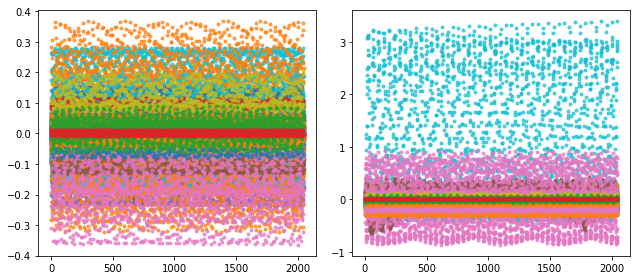

In [33]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

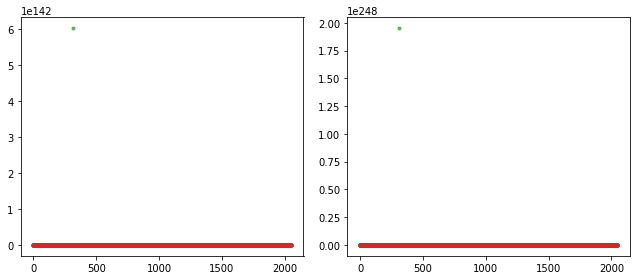

In [34]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

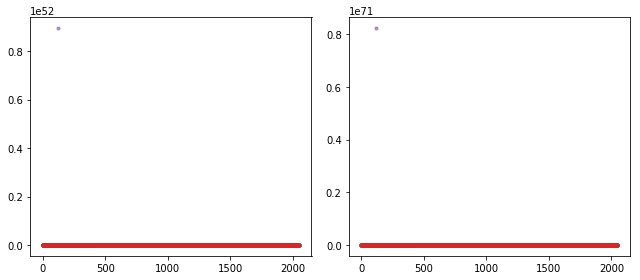

In [35]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(npt):
    plt.plot(Inv2[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(npt):
    plt.plot(Inv2[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()